<a href="https://colab.research.google.com/github/yslk327/Flood_Map_Metrics/blob/main/MD_RF_classifier_Landsat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Environment Setup and Initialization**

In [1]:
# Install the necessary libraries
!pip install earthengine-api geemap
!pip install pandas
!pip install rasterio
!pip install numpy
#pip install --upgrade geemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 78.9 MB/s eta 0:00:00


In [2]:


# Import the libraries

import ee
import geemap
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from google.colab import drive
import rasterio

# Earth Engine Authentication
ee.Authenticate()
ee.Initialize(project='ee-yassineloukili')


In [3]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


**Loading LANDSAT Data and Study Area Definitions**

In [68]:
# Load image and sample data: Tetouan, Morocco
"""
#geometry_area = ee.FeatureCollection("projects/ee-yassineloukili/assets/AnalysisExtent_Tetouan")  #
geometry_area = ee.FeatureCollection("projects/ee-yassineloukili/assets/extent_Tetouan")  #  Study area Tetouan, Morocco
water_extent_area = ee.FeatureCollection("projects/ee-yassineloukili/assets/water_Extent_Tetouan")  #  Flooded area Tetouan, Morocco
other_data = ee.FeatureCollection("projects/ee-yassineloukili/assets/other_data_tetouan_400")  # Other training sample Tetouan, Morocco
water_data = ee.FeatureCollection("projects/ee-yassineloukili/assets/water_data2_tetouan_400")  # Water training sample Tetouan, Morocco
#water_data = ee.FeatureCollection("projects/ee-yassineloukili/assets/water_data_tetouan_100")
# Date range for the analysis period
startdate = ee.Date.fromYMD(2021,1,1)
enddate = ee.Date.fromYMD(2021,1,15)
"""
# Load image and sample data: Matam, Senegal

geometry_area = ee.FeatureCollection("projects/ee-yassineloukili/assets/AnalysisExtent_Matam_Senegal_20241025")  #  Study area Matam_Senegal
water_extent_area = ee.FeatureCollection("projects/ee-yassineloukili/assets/water_Extent_Matam_Senegal_20241025")  #  Flooded area Matam_Senegal (UNOSAT)
other_data = ee.FeatureCollection("projects/ee-yassineloukili/assets/other_data_Senegal_400")  # Other training sample Matam, Senegal
water_data = ee.FeatureCollection("projects/ee-yassineloukili/assets/water_data_Senegal_400")  # Water training sample Matam, Senegal
# Date range for the analysis period
startdate = ee.Date.fromYMD(2024,10,1)
enddate = ee.Date.fromYMD(2024,10,30)

# Load Landsat collections
landsat7 = ee.ImageCollection("LANDSAT/LE07/C02/T1_RT_TOA").filterBounds(geometry_area).filterDate(startdate, enddate)
landsat8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_RT_TOA").filterBounds(geometry_area).filterDate(startdate, enddate)
landsat9 = ee.ImageCollection("LANDSAT/LC09/C02/T1_TOA").filterBounds(geometry_area).filterDate(startdate, enddate)

# heck the bands in an image from the Landsat collection
#print("Band names in Landsat 8 image:", image.bandNames().getInfo())

# Function to apply a cloud mask
def cloud_mask(image,cloud_thresh=30):
    cloud_score = ee.Algorithms.Landsat.simpleCloudScore(image)
    quality = cloud_score.select('cloud')
    cloud01 = quality.gt(cloud_thresh)
    cloudmask = image.mask().And(cloud01.Not())
    return image.updateMask(cloudmask)

# Apply the cloud mask
landsat7mask = landsat7.map(cloud_mask)
landsat8mask = landsat8.map(cloud_mask)
landsat9mask = landsat9.map(cloud_mask)

# Select necessary bands
bands = ['B3', 'B5']
landsat7b = landsat7mask.select(bands)
landsat8b = landsat8mask.select(bands)
landsat9b = landsat9mask.select(bands)


# NDWI Calculation
def calculate_ndwi(image):
    ndwi = image.normalizedDifference(['B3', 'B5']).rename("NDWI")
    return image.addBands(ndwi)

landsat7ndwi = landsat7b.map(calculate_ndwi)
landsat8ndwi = landsat8b.map(calculate_ndwi)
landsat9ndwi = landsat9b.map(calculate_ndwi)

# Merge all collections and clip to the study area : Matam_Senegal
allcollection = ee.ImageCollection(landsat8ndwi.merge(landsat9ndwi)).mosaic().clip(geometry_area) #senegal

# Merge all collections and clip to the study area : Tetouan_Morocco
#allcollection = ee.ImageCollection(landsat7ndwi.merge(landsat8ndwi)).mosaic().clip(geometry_area) #morocco

# Check the bands
print("Bands in the merged collection:", allcollection.bandNames().getInfo())
bandNames3 = allcollection.bandNames()
print("Bands names:", bandNames3.getInfo())


Bands in the merged collection: ['B3', 'B5', 'NDWI']
Bands names: ['B3', 'B5', 'NDWI']


**Merging Training Data and Sampling Image Regions**

In [69]:
merge_col=water_data.merge(other_data);
print('Merge collection',merge_col.size().getInfo());

# Extract training samples from allcollection
Sample_LS = allcollection.sampleRegions(
    collection=merge_col,           # Collection training samples
    properties=["land_class"],      # Property indicating the classes (labels)
    scale=30                        # Spatial resolution (30m for LANDSAT)
)

# Check the structure of Sample_LS
print("Sample_LS size:", Sample_LS.size().getInfo())

Merge collection 800
Sample_LS size: 796


**Splitting Data into Training and Validation Sets**

In [70]:
# Add a random column
samples_with_random = Sample_LS.randomColumn()

# Split the samples: 70% for training, 30% for validation
training_samples = samples_with_random.filter(ee.Filter.gte("random", 0.3))
validation_samples = samples_with_random.filter(ee.Filter.lt("random", 0.3))

# Display the size of the sets
print("Number of training samples:", training_samples.size().getInfo())
print("Number of validation samples:", validation_samples.size().getInfo())

# Count the number of samples for each class in the training sample
training_class_counts = training_samples.aggregate_histogram('land_class')
training_class_counts_dict = training_class_counts.getInfo()
print("Class distribution in the training sample:")
for land_class, count in training_class_counts_dict.items():
    print(f"Classe {land_class}: {count}")

# Count the number of samples for each class in the validation sample
validation_class_counts = validation_samples.aggregate_histogram('land_class')
validation_class_counts_dict = validation_class_counts.getInfo()
print("Class distribution in the validation sample:")
for land_class, count in validation_class_counts_dict.items():
    print(f"Classe {land_class}: {count}")


Number of training samples: 558
Number of validation samples: 238
Class distribution in the training sample:
Classe 0: 274
Classe 1: 284
Class distribution in the validation sample:
Classe 0: 122
Classe 1: 116


**Training Classifier and Performance Evaluation**

In [71]:
# Train a smileRandomForest classifier
RF_classifier_ts = ee.Classifier.smileRandomForest(50).train(
    features=training_samples,
    classProperty="land_class",
    inputProperties=bandNames3
)

# Classify the validation samples
classified_validation_RF = validation_samples.classify(RF_classifier_ts)

# Calculate the confusion matrix
confusion_matrix = classified_validation_RF.errorMatrix("land_class", "classification")

# Calculate evaluation metrics
overall_accuracy = confusion_matrix.accuracy().getInfo()
user_accuracy = confusion_matrix.consumersAccuracy().getInfo()
producers_accuracy = confusion_matrix.producersAccuracy().getInfo()
kappa = confusion_matrix.kappa().getInfo()

print("smileRandomForest Classifier:")
print("Confusion Matrix:", confusion_matrix.getInfo())
print("User Accuracy:", user_accuracy)
print("Producers Accuracy:", producers_accuracy)
print("Overall Accuracy:", overall_accuracy)
print("Kappa Coefficient:", kappa)



smileRandomForest Classifier:
Confusion Matrix: [[115, 7], [2, 114]]
User Accuracy: [[0.9829059829059829, 0.9421487603305785]]
Producers Accuracy: [[0.9426229508196722], [0.9827586206896551]]
Overall Accuracy: 0.9621848739495799
Kappa Coefficient: 0.9244017787816756


In [72]:
# Train a minimumDistance classifier
MD_classifier_ts = ee.Classifier.minimumDistance().train(
    features=training_samples,
    classProperty="land_class",
    inputProperties=bandNames3
)
# Classify the validation samples
classified_validation_MD = validation_samples.classify(MD_classifier_ts)

# Calculate the confusion matrix
confusion_matrix = classified_validation_MD.errorMatrix("land_class", "classification")

# Calculate evaluation metrics
overall_accuracy = confusion_matrix.accuracy().getInfo()
user_accuracy = confusion_matrix.consumersAccuracy().getInfo()
producers_accuracy = confusion_matrix.producersAccuracy().getInfo()
kappa = confusion_matrix.kappa().getInfo()

print("minimumDistance Classifier:")
print("Confusion Matrix:", confusion_matrix.getInfo())
print("User Accuracy:", user_accuracy)
print("Producers Accuracy:", producers_accuracy)
print("Overall Accuracy:", overall_accuracy)
print("Kappa Coefficient:", kappa)


minimumDistance Classifier:
Confusion Matrix: [[73, 49], [1, 115]]
User Accuracy: [[0.9864864864864865, 0.7012195121951219]]
Producers Accuracy: [[0.5983606557377049], [0.9913793103448276]]
Overall Accuracy: 0.7899159663865546
Kappa Coefficient: 0.5837996642417459


**Converting GEE FeatureCollection to DataFrame**

In [73]:
# Add classifier predictions to validation samples
classified_validation_MD = classified_validation_MD.map(
    lambda feature: feature.set({"MD_prediction": feature.get("classification")})
)

classified_validation_RF = classified_validation_RF.map(
    lambda feature: feature.set({"RF_prediction": feature.get("classification")})
)

# Merge results to include both MD and RF predictions
classified_validation = classified_validation_RF.map(
    lambda feature: feature.set({
        "MD_prediction": classified_validation_MD.filter(
            ee.Filter.eq("system:index", feature.get("system:index"))
        ).first().get("MD_prediction")
    })
)

# Collect samples with their labels and predictions
results = classified_validation

# Convert data to Python format with a progress bar
def feature_collection_to_dataframe_with_progress(feature_collection):
    """Convert a GEE FeatureCollection to a pandas DataFrame avec barre de progression."""
    # Retrieve feature information
    features_list = feature_collection.toList(feature_collection.size()).getInfo()  # List of GEE features
    rows = []

    # Initialize progress bar
    for feature in tqdm(features_list, desc="Processing features"):
        rows.append(feature["properties"])

    return pd.DataFrame(rows)

# Download results with progress bar
print("Converting results...")
results_df = feature_collection_to_dataframe_with_progress(results)

print("Data collection completed!!!")



Converting results...


Processing features: 100%|██████████| 238/238 [00:00<00:00, 1615282.12it/s]

Data collection completed!!!


**ROC Curve Analysis for Classifier Performance**

AUC Value :
Random Forest (RF): 0.96
Minimum Distance (MD): 0.79

ROC Curve Points for RF:
Threshold: inf, FPR: 0.00, TPR: 0.00
Threshold: 1.00, FPR: 0.06, TPR: 0.98
Threshold: 0.00, FPR: 1.00, TPR: 1.00

ROC Curve Points for MD:
Threshold: inf, FPR: 0.00, TPR: 0.00
Threshold: 1.00, FPR: 0.40, TPR: 0.99
Threshold: 0.00, FPR: 1.00, TPR: 1.00


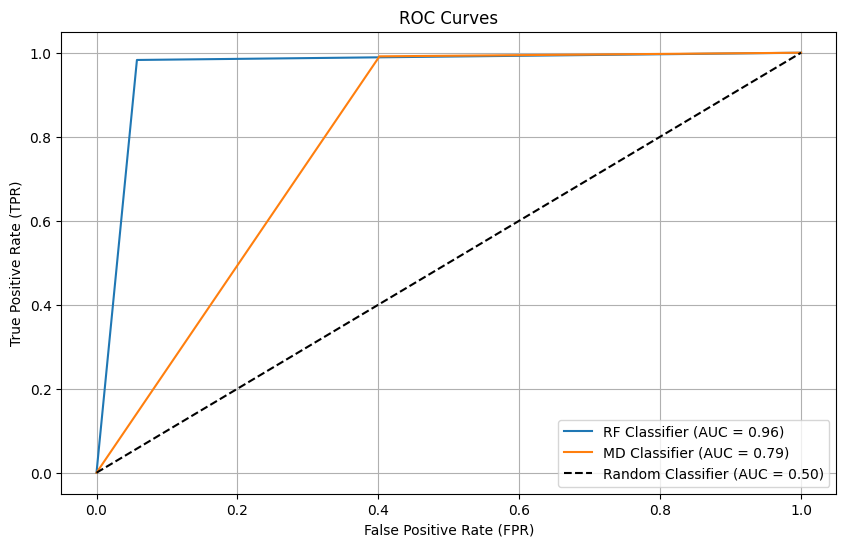

In [76]:
from sklearn.metrics import roc_curve, roc_auc_score

# Columns containing actual labels and predictions
true_labels = results_df["land_class"]  # Actual labels (0 or 1 for flooding)
rf_predictions = results_df["RF_prediction"]  # RF predictions
md_predictions = results_df["MD_prediction"]  # MD predictions

# Compute ROC curves and AUC for RF
fpr_rf, tpr_rf, thresholds_rf = roc_curve(true_labels, rf_predictions)
auc_rf = roc_auc_score(true_labels, rf_predictions)

# Compute ROC curves and AUC for MD
fpr_md, tpr_md, thresholds_md = roc_curve(true_labels, md_predictions)
auc_md = roc_auc_score(true_labels, md_predictions)

# Display AUC values
print("AUC Value :")
print(f"Random Forest (RF): {auc_rf:.2f}")
print(f"Minimum Distance (MD): {auc_md:.2f}")

# Display ROC curve points (FPR, TPR, and thresholds)
print("\nROC Curve Points for RF:")
for fpr, tpr, threshold in zip(fpr_rf, tpr_rf, thresholds_rf):
    print(f"Threshold: {threshold:.2f}, FPR: {fpr:.2f}, TPR: {tpr:.2f}")

print("\nROC Curve Points for MD:")
for fpr, tpr, threshold in zip(fpr_md, tpr_md, thresholds_md):
    print(f"Threshold: {threshold:.2f}, FPR: {fpr:.2f}, TPR: {tpr:.2f}")

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f"RF Classifier (AUC = {auc_rf:.2f})")
plt.plot(fpr_md, tpr_md, label=f"MD Classifier (AUC = {auc_md:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curves")
plt.legend(loc="best")
plt.grid()
plt.show()


**Cross-Validation for Model Performance Assessment**

In [77]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, balanced_accuracy_score


# Prepare data (adjust according to your dataset)
# Load validation samples from your script
Sample_LS_DATA = Sample_LS.getInfo()  # Ensure that validation_samples is already defined
data = Sample_LS_DATA ["features"]
data = pd.DataFrame([feat["properties"] for feat in data])
X = data[["B3", "B5", "NDWI"]]  # Feature columns
y = data["land_class"]               # Target column

# Define stratified cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store results
f1_scores_rf = []
balanced_accuracies_rf = []

f1_scores_md = []
balanced_accuracies_md = []

# Loop through each fold
for train_index, test_index in kfold.split(X, y):
    # Split data into training and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # 1. Random Forest Classifier
    from sklearn.ensemble import RandomForestClassifier
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)

    # Compute metrics
    f1_scores_rf.append(f1_score(y_test, y_pred_rf))
    balanced_accuracies_rf.append(balanced_accuracy_score(y_test, y_pred_rf))

    # 2. Minimum Distance Classifier
    from sklearn.neighbors import NearestCentroid
    md_model = NearestCentroid(metric='euclidean')  # Minimum distance-based classifier
    md_model.fit(X_train, y_train)
    y_pred_md = md_model.predict(X_test)

    # Compute metrics
    f1_scores_md.append(f1_score(y_test, y_pred_md))
    balanced_accuracies_md.append(balanced_accuracy_score(y_test, y_pred_md))

# Final results (mean and standard deviation)
print("Random Forest:")
print(f"F1-score: {np.mean(f1_scores_rf):.2f} ± {np.std(f1_scores_rf):.2f}")
print(f"Balanced Accuracy: {np.mean(balanced_accuracies_rf):.2f} ± {np.std(balanced_accuracies_rf):.2f}")

print("\nMinimum Distance:")
print(f"F1-score: {np.mean(f1_scores_md):.2f} ± {np.std(f1_scores_md):.2f}")
print(f"Balanced Accuracy: {np.mean(balanced_accuracies_md):.2f} ± {np.std(balanced_accuracies_md):.2f}")

Random Forest:
F1-score: 0.97 ± 0.01
Balanced Accuracy: 0.97 ± 0.01

Minimum Distance:
F1-score: 0.83 ± 0.01
Balanced Accuracy: 0.80 ± 0.02


**Combined Flooded Area Calculation from RF and MD Classifiers**

In [78]:
# Training Minimum Distance Classifiers
MD_classifier = ee.Classifier.minimumDistance().train(
    features=Sample_LS,
    classProperty="land_class",
    inputProperties=bandNames3
)
# Apply the classifier
MD_classification= allcollection.classify(MD_classifier)

###########################################################################
#Training Random Forest Classifiers
RF_classifier = ee.Classifier.smileRandomForest(50).train(
    features=Sample_LS,
    classProperty="land_class",
    inputProperties=bandNames3
)

# Apply the classifier
RF_classification= allcollection.classify(RF_classifier)

combined_classification = RF_classification.eq(1).Or(MD_classification.eq(1))

# Calculate the area of flooded zones
pixel_area_RF = RF_classification.multiply(ee.Image.pixelArea())
# Calculate the total flooded area
total_flooded_area_RF = pixel_area_RF.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=geometry_area,
    scale=30,
    maxPixels=1e13
)
# Convert to hectares
flooded_area_ha_RF = ee.Number(total_flooded_area_RF.get("classification")).divide(10000)
print("Total extent of detected water surface (ha)-RF:", flooded_area_ha_RF.getInfo())

###########################################################################################
pixel_area_MD = MD_classification.multiply(ee.Image.pixelArea())
# Calculate the total flooded area
total_flooded_area_MD = pixel_area_MD.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=geometry_area,
    scale=30,
    maxPixels=1e13
)
# Convert to hectares
flooded_area_ha_MD = ee.Number(total_flooded_area_MD.get("classification")).divide(10000)
print("Total extent of detected water surface (ha)-MD:", flooded_area_ha_MD.getInfo())


###########################################################################################
pixel_area = combined_classification.multiply(ee.Image.pixelArea())
# Calculate the total flooded area
total_flooded_area = pixel_area.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=geometry_area,
    scale=30,
    maxPixels=1e13
)
# Convert to hectares
flooded_area_ha = ee.Number(total_flooded_area.get("classification")).divide(10000)
print("Total extent of detected water surface (ha)- RF & MD :", flooded_area_ha.getInfo())

################################################# Extent permanentWater ###################
#the Copernicus Global Land Service (CGLS) land cover map (100m)
CGLS=ee.Image("COPERNICUS/Landcover/100m/Proba-V-C3/Global/2019")
landcover = CGLS.select('discrete_classification')
landcover_area = landcover.clip(geometry_area)

#Extract only water pixels from CGLS using class value equal to 80 or 200
water = landcover_area.eq(80).Or(landcover_area.eq(200))

#extent permanentWater
inundation_area_PW = water.multiply(ee.Image.pixelArea())

# Sum the area covered by inundated pixels.
inundation_stats_PW = inundation_area_PW.reduceRegion (
   reducer= ee.Reducer.sum(),
   geometry= geometry_area,
   scale= 30,
   maxPixels= 1e13,
   bestEffort= True
  )
# Convertir PW en hectares
PW_area_ha = ee.Number(inundation_stats_PW.get("discrete_classification")).divide(10000)
print("Permanent water extent (ha):", PW_area_ha.getInfo())
###############################################################################################
#Total flooded surface
surf_total_RF=flooded_area_ha_RF.subtract(PW_area_ha)
print("Total flood surface (ha)-RF :", surf_total_RF.getInfo())
surf_total_MD=flooded_area_ha_MD.subtract(PW_area_ha)
print("Total flood surface (ha)-MD :", surf_total_MD.getInfo())
surf_total=flooded_area_ha.subtract(PW_area_ha)
print("Total flood surface (ha)-RF & MD :", surf_total.getInfo())

Total extent of detected water surface (ha)-RF: 40803.57702262069
Total extent of detected water surface (ha)-MD: 43058.327433527025
Total extent of detected water surface (ha)- RF & MD : 44250.46494556708
Permanent water extent (ha): 1448.5458304881138
Total flood surface (ha)-RF : 39355.03119213258
Total flood surface (ha)-MD : 41609.781603038915
Total flood surface (ha)-RF & MD : 42801.91911507897


**Area Calculation for Water Extent Features( UNOSAT)**

In [79]:
# Calculate the areas in square meters for each entity and add as a property
water_extent_area_with_area = water_extent_area.map(lambda feature:
    feature.set({'area_m2': feature.geometry().area()}))

# Extract the sum of the areas
total_area_m2 = water_extent_area_with_area.aggregate_sum('area_m2')

# Convert to hectares
total_area_ha = total_area_m2.divide(10000)

# Print the result
print("Total area in hectares:", total_area_ha.getInfo())

Area_Difference = total_area_ha.subtract(surf_total).abs()
print("Area difference :", Area_Difference.getInfo())

Total area in hectares: 57005.429714865924
Area difference : 14203.510599786954


**Visualization of Landsat Imagery and Classification Results**

In [80]:
vis_params = {
    'bands': ['B4', 'B3', 'B2'],  # RGB
    'max': 0.3
}

l9bands = landsat9.select(['B4', 'B3', 'B2']).mosaic()
l8bands = landsat8.select(['B4', 'B3', 'B2']).mosaic()
l7bands = landsat7.select(['B4', 'B3', 'B2']).mosaic()

# Create a map and display the results
Map = geemap.Map()
Map.centerObject(geometry_area, 10)
# Add images Landsat 7,8 et 9
Map.addLayer(l7bands, vis_params, 'true color landsat7', 0)
Map.addLayer(l8bands, vis_params, 'true color landsat8', 0)
Map.addLayer(l9bands, vis_params, 'true color landsat9', 0)

#Map.add_basemap("Esri.NatGeoWorldMap")
#Map.add_basemap("SATELLITE")
#Map.add_basemap("BaseMapDE.Color")

# Add flooded areas
Map.addLayer(water_extent_area, {}, "Zone Inondées unosat", 1)

Map.addLayer(combined_classification.updateMask(combined_classification), {'palette': 'red'}, 'Combined Flood', 0)
Map.addLayer(MD_classification.updateMask(MD_classification.eq(1)), {'palette': 'yellow'}, 'Minimum Distance Flood', 1)
Map.addLayer(RF_classification.updateMask(RF_classification.eq(1)), {'palette': 'green'}, 'Random Forest Flood', 1)
#Add reference data points into the map to visualize
Map.addLayer(water_data.draw("blue"),{},"water",0)
Map.addLayer(other_data.draw("yellow"),{},"other",0)


Map.addLayer(water.selfMask(), {'palette': 'blue'}, 'Permanent water', 1)
#  Add the study area
Map.addLayer(geometry_area, {}, "Study area", 0)
#  Display the map
Map.to_html("map_senegal_matam_MD_RF_landsat_400_water.html")
#Map.to_html("map_tetouan_morocco_MD_RF_landsat_400_water.html")
print("Carte enregistrée!")
Map

Carte enregistrée!


Map(center=[15.612321468851183, -13.22149672209397], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:

task = ee.batch.Export.image.toDrive(
    image=combined_classification,
    description="classification_MD_RF_senegal_matam_landsat_400pt_water",
    #description="classification_MD_RF_morocco-tetouan_landsat_400pt_water",
    folder="GEE_Exports",
    fileNamePrefix="classification_Md_RF_senegal_matam_landsat_400pt_water",
    #fileNamePrefix="classification_Md_RF_morocco-tetouan_landsat_400pt_water",
    region=geometry_area.geometry(),
    scale=30,
    crs='EPSG:4326',
    maxPixels=1e13
)
task.start()


**Calculating IoU,Overlap Percentage,Commission Error and Omission**

In [81]:
from osgeo import gdal

def align_rasters(reference_path, target_path, output_path):
    """Align the target raster to match the reference raster."""
    reference = gdal.Open(reference_path)
    target = gdal.Open(target_path)

    reference_proj = reference.GetProjection()
    reference_geotransform = reference.GetGeoTransform()
    x_res = reference.RasterXSize
    y_res = reference.RasterYSize

    driver = gdal.GetDriverByName("GTiff")
    aligned_target = driver.Create(
        output_path,
        x_res,
        y_res,
        1,
        gdal.GDT_Int32
    )

    aligned_target.SetGeoTransform(reference_geotransform)
    aligned_target.SetProjection(reference_proj)

    gdal.ReprojectImage(
        target,
        aligned_target,
        target.GetProjection(),
        reference_proj,
        gdal.GRA_NearestNeighbour
    )
    aligned_target.FlushCache()

def calculate_metrics(reference_path, aligned_target_path):
    """Calculate intersection, union, IoU, overlap percentage, commission error, and omission error."""
    with rasterio.open(reference_path) as ref_src:
        ref_array = ref_src.read(1)
        ref_array = np.where(ref_array == ref_src.nodata, 0, ref_array)
        ref_array = np.where(ref_array == 1, 1, 0)  # Binary water mask

    with rasterio.open(aligned_target_path) as tgt_src:
        tgt_array = tgt_src.read(1)
        tgt_array = np.where(tgt_array == tgt_src.nodata, 0, tgt_array)
        tgt_array = np.where(tgt_array == 1, 1, 0)  # Binary water mask

        print(f"Benchmark map: {ref_array.sum()}")
        print(f"Prediction map: {tgt_array.sum()}")

    # Calculate Intersection and Union
    intersection = np.logical_and(ref_array, tgt_array).sum()
    union = np.logical_or(ref_array, tgt_array).sum()

    # IoU Calculation
    iou = (intersection / union) * 100 if union != 0 else 0

    # Overlap Percentage Calculation
    overlap_percentage = (intersection / ref_array.sum()) * 100 if ref_array.sum() != 0 else 0

    # Commission Error: False Positives / (True Positives + False Positives)
    false_positives = np.logical_and(tgt_array == 1, ref_array == 0).sum()
    true_positives = intersection
    commission_error = false_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0

    # Omission Error: False Negatives / (True Positives + False Negatives)
    false_negatives = np.logical_and(tgt_array == 0, ref_array == 1).sum()
    omission_error = false_negatives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0

    return intersection, union, iou, overlap_percentage, commission_error, omission_error

# File paths : senegal_matam
benchmark_map_path = "/content/drive/MyDrive/GEE_Exports/WaterExtent_MatamDepartment_PolygonToRaster_20241025.tif"
predicted_map_path = "/content/drive/MyDrive/GEE_Exports/LANDSAT/classification_Md_RF_senegal_matam_landsat_400pt_water.tif"
aligned_predicted_path = "/content/drive/MyDrive/GEE_Exports/LANDSAT/aligned_predicted_Md_RF_senegal_matam_landsat_400pt_water.tif"

# File paths : morocco-tetouan
#benchmark_map_path = '/content/drive/MyDrive/GEE_Exports/WaterExtent_Tetouan_PolygonToRaster_Pleiades.tif'
#predicted_map_path = '/content/drive/MyDrive/GEE_Exports/LANDSAT/classification_Md_RF_morocco-tetouan_landsat_400pt_water.tif'
#aligned_predicted_path = "/content/drive/MyDrive/GEE_Exports/LANDSAT/aligned_predicted_Md_RF_morocco-tetouan_landsat_400pt_water.tif"


# Step 1: Align rasters
align_rasters(benchmark_map_path, predicted_map_path, aligned_predicted_path)

# Step 2: Calculate metrics
intersection, union, iou, overlap_percentage, commission_error, omission_error = calculate_metrics(benchmark_map_path, aligned_predicted_path)

# Step 3: Print results
print("Metrics:")
print(f"Intersection: {intersection}")
print(f"Union: {union}")
print(f"IoU: {iou:.2f}%")
print(f"Overlap Percentage: {overlap_percentage:.2f}%")
print(f"Commission Error: {commission_error * 100:.2f}%")
print(f"Omission Error: {omission_error * 100:.2f}%")


Benchmark map: 4787251
Prediction map: 3729797
Metrics:
Intersection: 3651142
Union: 4865906
IoU: 75.04%
Overlap Percentage: 76.27%
Commission Error: 2.11%
Omission Error: 23.73%
